# ĐỒ ÁN: DỰ ĐOÁN GIÁ XE PHÂN KHỐI LỚN 
## Môn học : Phân tích dữ liệu - IE224.O11
## Nhóm 27 - Sinh viên thực hiện:
+ Nguyễn Phú Trung: 21521592
+ Lê Quốc Kiệt: 21521031
+ Tạ Anh Khoa: 21522232

## I. Sắp xếp dữ liệu

#### Import thư viện và đọc bộ dữ liệu

In [1]:
import numpy as np
import pandas as pd

In [2]:
#Set giao diện
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
#Thực hiện đọc dataset => Dataframe E:\Courses\ki5\DA_IE224\Project\Official\San_pham\Code Demo\new_PKL_dataset.csv
data_path = 'new_PKL_dataset.csv'
df = pd.read_csv(data_path)

### 1. Định dạng và dọn dẹp dữ liệu

#### Thực hiện định dạng và chia nhỏ các cột chứa dữ liệu (nhiều biến) thành từng cột chỉ lưu trữ 1 loại dữ liệu (1 biến) với hàm format_cols do nhóm tự định nghĩa

##### Cột Engine-Type : chỉ lấy giá trị đầu tiên và giá trị cuối cùng tương ứng với cylinders và enginetype. Giá trị tương ứng bị khuyết sẽ điền "Not provided". Tất cả được thực hiện dựa trên hàm split_engine_to_new_df trong module enginetype_split.py

In [4]:
#Import module enginetype_split
import format_cols as fc

In [5]:
#Thực hiện split giá trị của cột Engine-Type thành 1 dataframe 2 cột lưu vào biến two_cols
two_cols = fc.split_engine_to_new_df(df['Engine-Type'])

#Thêm 2 cột mới vào dataframe và xóa cột Engine-Type cũ đi.
df = df.join(two_cols)
df.drop('Engine-Type', axis=1, inplace= True)


##### Biến price: Loại bỏ dấu phẩy (,)

In [6]:
df['Price'] = df['Price'].replace(',','',regex=True)

##### Biến power: Giá trị của cột power có dạng 29/40 trong đó, 29 là Wh = 40 horsepower => Chỉ lấy giá trị tương ứng với đơn vị horsepower. Nếu giá trị của có thông tin về Factory thì lấy giá trị ngoài Factory (VD 29/40 Factory(30/41 thì dùng 40)).

In [7]:
df['Power'] = df['Power'].str.extract('(\d+)')

##### Biến Cubic-capacity xử lí tương tự cột power

In [8]:
df['Cubic-capacity'] = df['Cubic-capacity'].str.extract('(\d+)')

##### Biến Mileage: Đang ở 2 đơn vị mls (miles) và km (kilometer) => Chuyển về km (Nếu Not provided thì chuyển về None) bằng cách sử dụng hàm convert_mls_to_km trong module format_cols


In [9]:
df['Mileage'] = df['Mileage'].apply(fc.convert_mls_to_km)

In [10]:
#Thay đổi lại vị trí cột trong Dataframe:
new_ordered_name = ['Make', 'Model', 'Type', 'Year-of-manufacture', 'Mileage',
       'Engine-type', 'Power', 'Cubic-capacity', 'Cylinders','Cylinder-type', 'Cooling', 'Gears', 'Transmission',
       'Curb-weight', 'Exterior-color', 'Price']
df = df[new_ordered_name]

### 2. Xử lí giá trị khuyết


##### Thay thế các giá trị "Not provided" bằng NaN:

In [11]:
# Thay thế giá trị "Not provided" bằng NaN
df.replace('Not provided', np.nan, inplace=True)
nan_counts = df.isna().sum()
# Xuất ra tên cột cùng số lượng biến bị khuyết tương ứng:
nan_counts

Make                     0
Model                    0
Type                     0
Year-of-manufacture      0
Mileage                 13
Engine-type            154
Power                    0
Cubic-capacity           0
Cylinders                5
Cylinder-type          144
Cooling                 21
Gears                   65
Transmission            51
Curb-weight            109
Exterior-color           0
Price                    0
dtype: int64

#### Thực hiện drop cột Engine-type và Cylinder-type do có quá nhiều giá trị khuyết

In [12]:
df.drop('Cylinder-type', axis = 1, inplace = True)
df.drop('Engine-type', axis = 1, inplace = True)

In [13]:
#Lấy danh sách các cột có nan
columns_with_nan = df.columns[df.isna().any()].tolist()

#### Xử lí các biến bị khuyết với các yêu cầu:
+ Mileage, Curb-weight thay thế bằng mean để không ảnh hưởng nhiều đến bộ dữ liệu.
+ Power, Gears thay thế bằng mode cùng Make, nếu không có thì thay bằng mode(Engine_type) để đảm bảo tính đúng đắn của dữ liệu do xe có cùng hãng thì các thông số trên thường giống nhau.
+ Cylinders, Cooling, Transmission thay thế bằng mode do các biến này là biến phân loại nên các giá trị thường gần với mode và số lượng giá trị khuyết ít.

In [14]:
# Mileage, Curb-weight thay thế bằng mean
for col in ['Mileage', 'Curb-weight']:
    val = (df[col].mode().values[0])
    df[col].replace(
        to_replace=np.nan,
        value = val,
        inplace=True
    )

In [15]:
# Power, Gears thay thế bằng mode của xe cùng Make, nếu không có thì thay bằng mode của từng biến như bình thường.
for col in ['Power', 'Gears']:
    mode_e = df[col].mode()
    mode_engine_type_by_make = df.groupby('Make')[col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else mode_e.values[0]).to_dict()
    df[col] = df.apply(lambda row: mode_engine_type_by_make[row['Make']] if pd.isna(row[col]) else row[col], axis=1)


In [16]:
#Cylinders, Cooling, Transmission thay thế bằng mode
for col in ['Cylinders', 'Cooling', 'Transmission']:
    val = (df[col].mode().values).tolist()[0]
    df[col].replace(
        to_replace=np.nan,
        value = val,
        inplace=True
    )

#### Kiểm tra lại các biến có còn bị khuyết hay không

In [17]:
df.isna().sum()

Make                   0
Model                  0
Type                   0
Year-of-manufacture    0
Mileage                0
Power                  0
Cubic-capacity         0
Cylinders              0
Cooling                0
Gears                  0
Transmission           0
Curb-weight            0
Exterior-color         0
Price                  0
dtype: int64

### 3. Xử lí các biến ngoại lệ:

####  Xóa các sample có Mileage < 9 do xe cũ thì không thể chạy dưới 9 km 

In [18]:
df.drop(df[df['Mileage'] < 9].index,inplace= True)

## II.Chuẩn hóa dữ liệu

##### Thực hiện chuyển kiểu dữ liệu về kiểu dữ liệu thích hợp

In [19]:
for col in df.columns:
    if df[col].dtype == 'object' and all(df[col].apply(fc.is_numeric)):
        df[col] = pd.to_numeric(df[col])

##### Kiểm tra lại kiểu dữ liệu của bộ dữ liệu

In [20]:
df.dtypes

Make                    object
Model                   object
Type                    object
Year-of-manufacture      int64
Mileage                float64
Power                    int64
Cubic-capacity           int64
Cylinders                int64
Cooling                 object
Gears                    int64
Transmission            object
Curb-weight            float64
Exterior-color          object
Price                    int64
dtype: object

### Xuất bộ dữ liệu ra file excel

In [21]:
df.to_excel('E:\\Courses\\ki5\\DA_IE224\\Project\\Official\\new_validated_dataset.xlsx')

## III. Mô tả sơ bộ bộ dữ liệu

### 1. Các đặc tính của bộ dữ liệu

In [22]:
print(f'Bộ dữ liệu có {df.shape[0]} sample và {df.shape[1]} cột')

Bộ dữ liệu có 285 sample và 14 cột


In [23]:
df.describe()

,Year-of-manufacture,Mileage,Power,Cubic-capacity,Cylinders,Gears,Curb-weight,Price
count,285.00,285.00,285.00,285.00,285.00,285.00,285.00,285.00
mean,1992.74,29414.42,55.13,760.10,2.47,5.21,0.17,11423.19
std,9.24,27384.56,36.08,388.07,1.25,0.76,0.08,12188.84
min,1980.00,9.00,0.00,1.00,1.00,3.00,0.07,2570.00
25%,1984.00,7850.00,30.00,500.00,2.00,5.00,0.08,3856.00
50%,1992.00,23407.00,53.00,851.00,2.00,5.00,0.19,6598.00
75%,1999.00,42200.00,82.00,998.00,4.00,6.00,0.22,14139.00
max,2019.00,124800.00,147.00,1832.00,6.00,6.00,0.39,94259.00


In [24]:
#Tạo numeric_df lấy các biến kiểu số trong bộ dữ liệu
numeric_df = df.select_dtypes(include = ['int','float'])
numeric_df.drop('Price', axis=1, inplace=True)

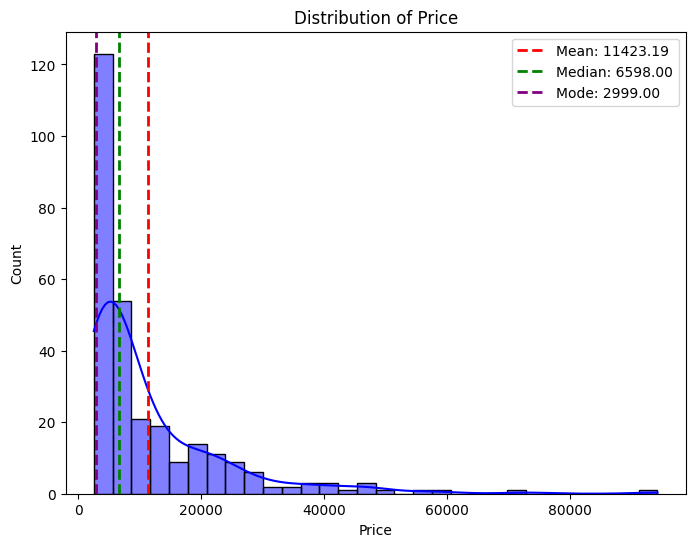

In [25]:
# Phân phối của biến price
import matplotlib.pyplot as plt
import seaborn as sns


# Vẽ histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True, color='blue', bins=30)
plt.title('Distribution of Price')

# Vẽ đường trung bình (mean)
mean_price = df['Price'].mean()
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_price:.2f}')

# Vẽ đường trung vị (median)
median_price = df['Price'].median()
plt.axvline(median_price, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_price:.2f}')

# Vẽ mode
mode_price = df['Price'].mode()[0]
plt.axvline(mode_price, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_price:.2f}')


plt.legend()
plt.show()


### 2. Phân tích độ lệch và trạng thái của biến số:

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

Year-of-manufacture đang mất cân đối (skewness = 0.540295562546748)
Mileage đang mất cân đối (skewness = 1.1642280918418761)
Power tương đối gần mức đối xứng (skewness = 0.30137571202617813)


Cubic-capacity tương đối gần mức đối xứng (skewness = -0.38181301963691083)
Cylinders đang mất cân đối (skewness = 0.756978663828293)
Gears đang mất cân đối (skewness = -1.046284219827742)
Curb-weight tương đối gần mức đối xứng (skewness = 0.07468780950454733)


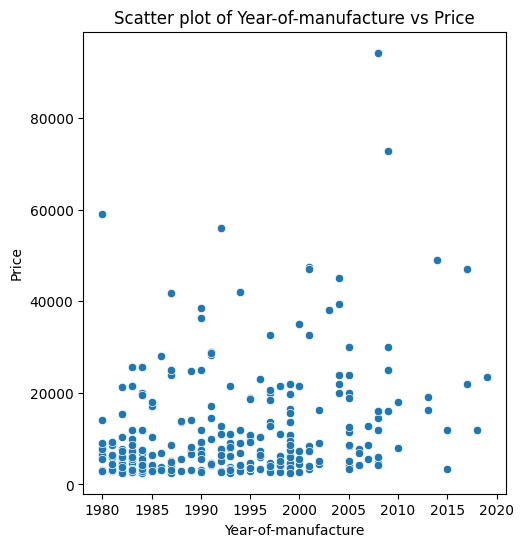

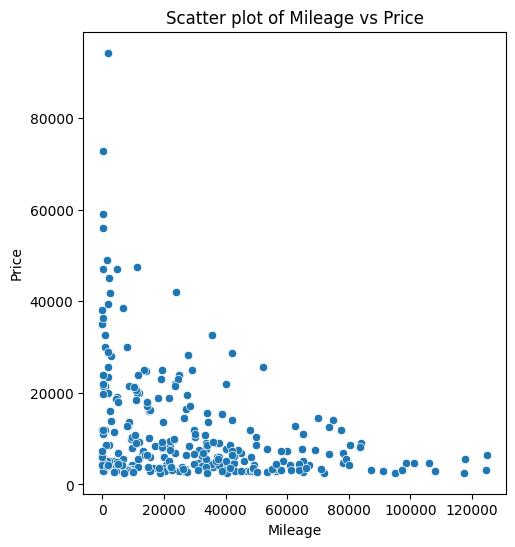

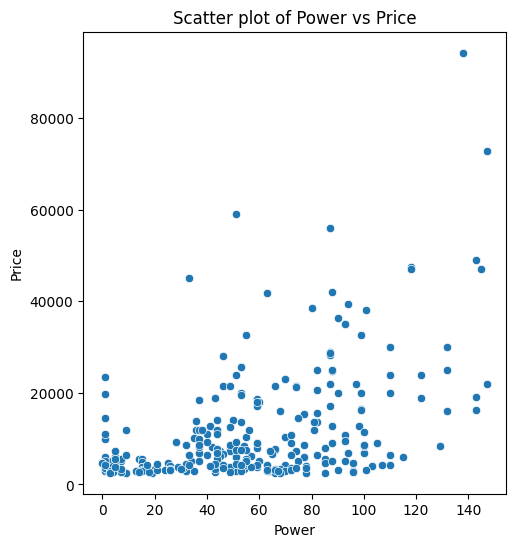

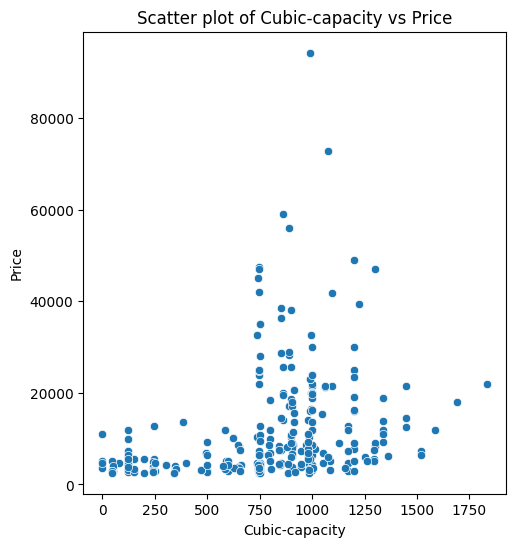

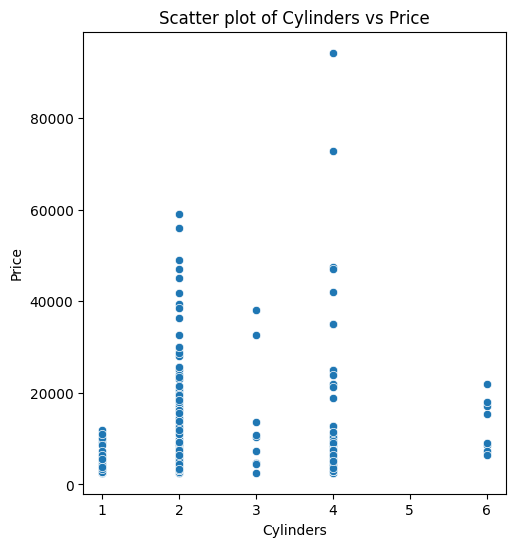

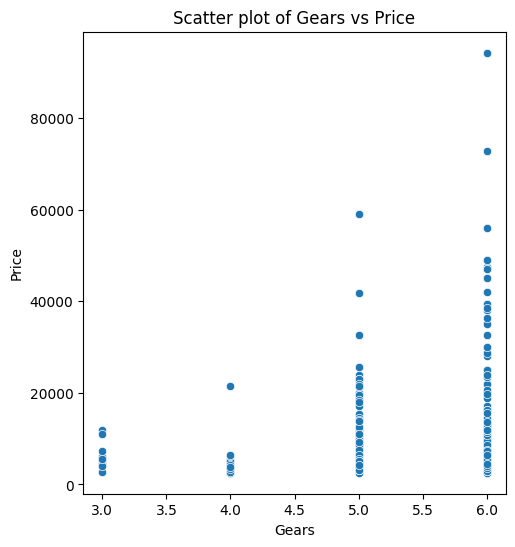

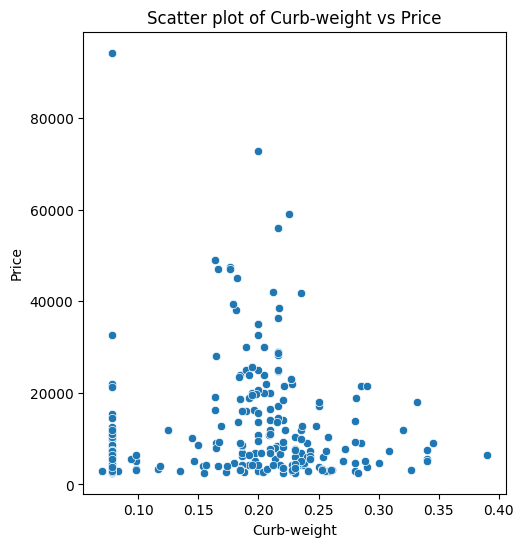

In [27]:
for column in numeric_df:
    #Có thể trực quan với boxplot để thấy rõ
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df[column], y=df['Price'])
    plt.title(f'Scatter plot of {column} vs Price')
    skewness = df[column].skew()
    if skewness > -0.5 and skewness < 0.5:
        print(f'{column} tương đối gần mức đối xứng (skewness = {skewness})')
    else:
        print(f'{column} đang mất cân đối (skewness = {skewness})')


### 3. Hình dạng của dữ liệu

In [28]:
# Tính toán kurtosis cho từng biến
kurtosis_values = numeric_df.kurtosis()

# Xác định ngưỡng để xem biến nào có giá trị kurtosis cao
threshold = 1  #ngưỡng 

outliers = kurtosis_values[abs(kurtosis_values) > threshold]

# Hiển thị các biến có giá trị kurtosis cao
print("Các biến có giá trị kurtosis cao:")
print(outliers)

Các biến có giá trị kurtosis cao:
Mileage   1.09
Gears     1.34
dtype: float64


### 4. Thể hiện các giá trị ngoại lệ qua boxplot

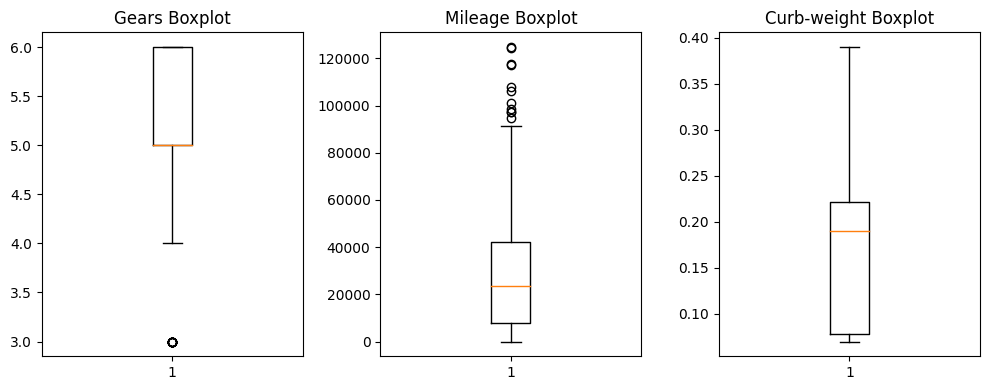

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.boxplot('Gears', data = df)
plt.title('Gears Boxplot')

plt.subplot(1,3,2)
plt.boxplot('Mileage', data = df)
plt.title('Mileage Boxplot')

plt.subplot(1,3,3)
plt.boxplot('Curb-weight', data = df)
plt.title('Curb-weight Boxplot')
plt.tight_layout()
plt.show()

## IV. Kết quả phân tích

### 1. Chọn lọc các biến số có ảnh hưởng đến giá bằng phân tích tương quan Pearson:
+ Có ảnh hưởng khi abs(p_coef) > 0.3 và p_value < 0.05

In [30]:
#create function to check if price is affected by init
def is_Affected(p_value, p_coef):
  if p_value >= 0.05: return 'Không ảnh hưởng'
  if p_coef >= -0.3 and p_coef <= 0.3:
    return 'Không ảnh hưởng'
  else:
    return 'Có ảnh hưởng'

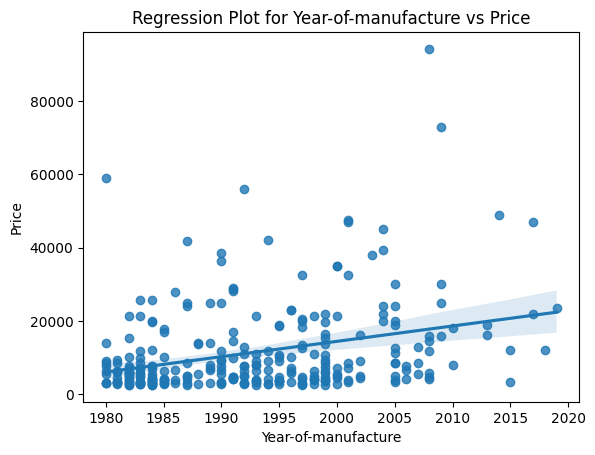


Correlation Coefficient and p-value for Year-of-manufacture vs Price:
Correlation Coefficient: 0.31757428476211785
P-value: 4.247840493032682e-08
Có ảnh hưởng


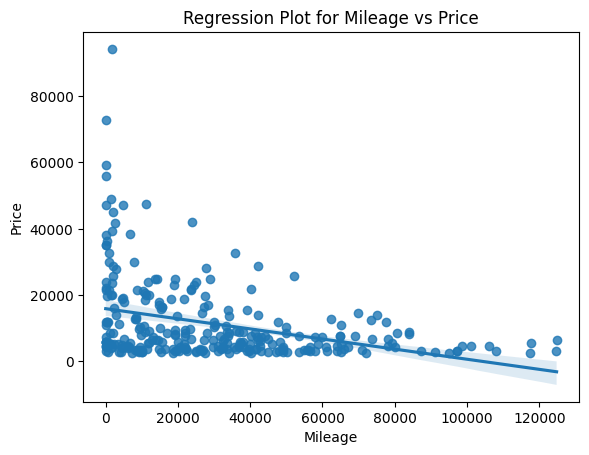


Correlation Coefficient and p-value for Mileage vs Price:
Correlation Coefficient: -0.34265544743762616
P-value: 2.8492156579955932e-09
Có ảnh hưởng


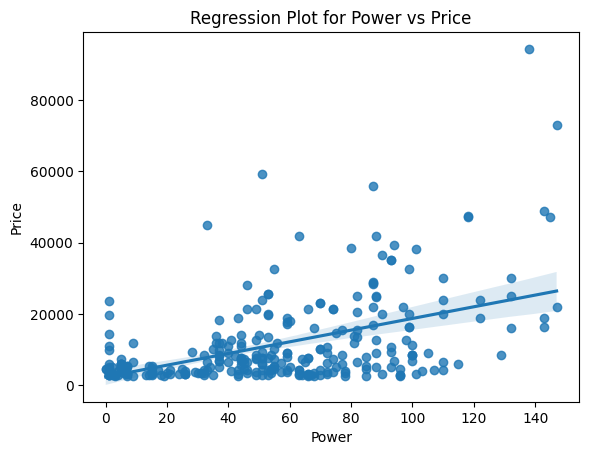


Correlation Coefficient and p-value for Power vs Price:
Correlation Coefficient: 0.48405770911532614
P-value: 3.795481747283153e-18
Có ảnh hưởng


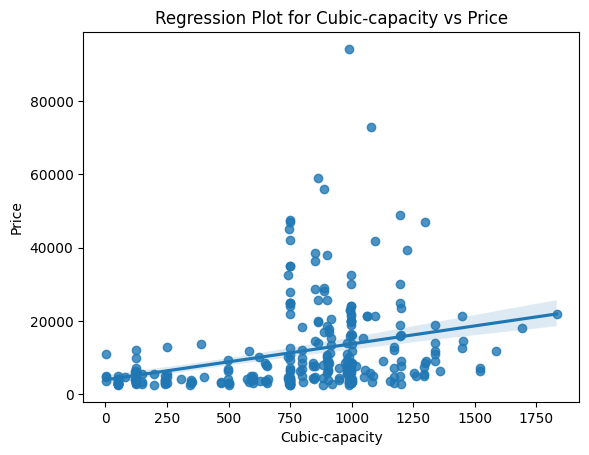


Correlation Coefficient and p-value for Cubic-capacity vs Price:
Correlation Coefficient: 0.3122636454523138
P-value: 7.298302016386496e-08
Có ảnh hưởng


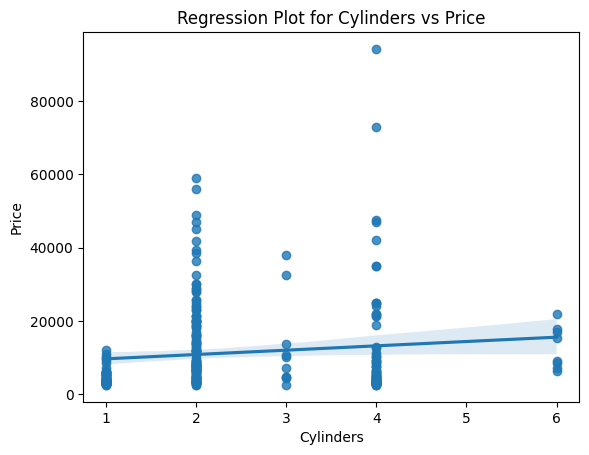


Correlation Coefficient and p-value for Cylinders vs Price:
Correlation Coefficient: 0.1215247075821195
P-value: 0.040348695846420674
Không ảnh hưởng


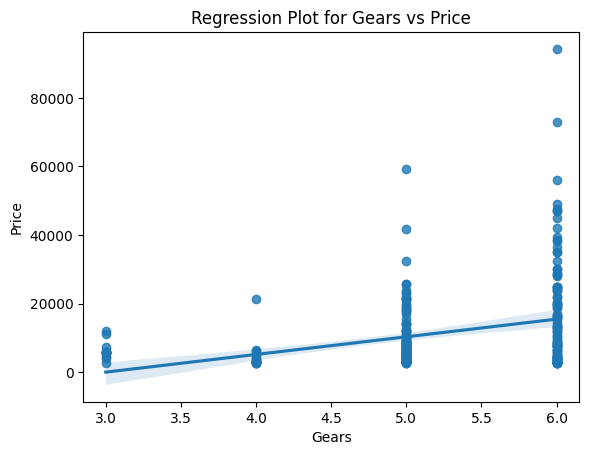


Correlation Coefficient and p-value for Gears vs Price:
Correlation Coefficient: 0.3224044242195248
P-value: 2.572601672122601e-08
Có ảnh hưởng


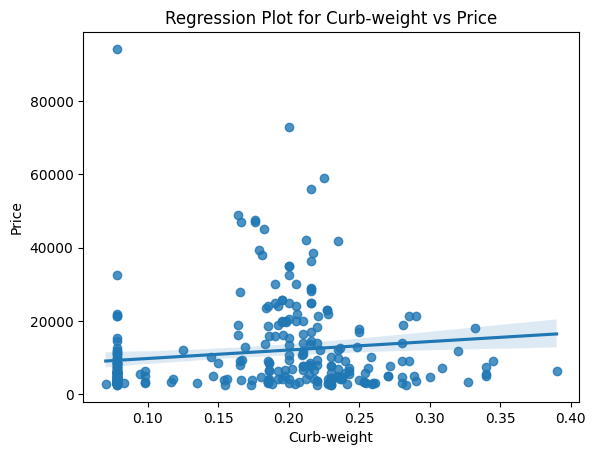


Correlation Coefficient and p-value for Curb-weight vs Price:
Correlation Coefficient: 0.1424136234395728
P-value: 0.01613143826656416
Không ảnh hưởng


In [31]:
from scipy import stats
numeric_df = df.select_dtypes(include = ['int','float'])

# Chọn các biến số kiểu số để xem xét
numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns


# Tạo một matrix scatter plot cho từng biến số so với giá xe
for var in numerical_vars:
    if var == 'Price':
        continue
    sns.regplot(x=var, y='Price', data=numeric_df)
    plt.title(f'Regression Plot for {var} vs Price')
    plt.show()

    # Tính hệ số tương quan và p-value bằng stats.pearsonr
    corr_coef, p_value = stats.pearsonr(numeric_df[var], df['Price'])
    
    print(f'\nCorrelation Coefficient and p-value for {var} vs Price:')
    print(f'Correlation Coefficient: {corr_coef}')
    print(f'P-value: {p_value}')
    print(is_Affected(p_value, corr_coef))

### 2. Chọn lọc các biến phân loại ảnh hưởng đến giá bằng phân tích ANOVA

In [32]:
from scipy.stats import f_oneway


# Chọn các biến phân loại cần xem xét
categorical_vars = df.select_dtypes(include=['object']).columns
df_categorical = df.select_dtypes(include=['object'])
df_categorical['Price'] = df['Price'].copy()

significant_categorical_vars = []
# Thực hiện phân tích phương sai (ANOVA) cho từng biến phân loại
for var in categorical_vars:
    groups = [df_categorical[df_categorical[var] == group]['Price'] for group in df_categorical[var].unique()]
    f_statistic, p_value = f_oneway(*groups)
    
    print(f'\nANOVA for {var} vs Price:')
    print(f'F-Statistic: {f_statistic}')
    print(f'P-value: {p_value}')
    if p_value < 0.05:
        print(f'{var} có ảnh hưởng đến giá')
        significant_categorical_vars.append(var)
        
print(f'\nBiến phân loại có ảnh hưởng đến giá: {significant_categorical_vars}')



ANOVA for Make vs Price:
F-Statistic: 4.27850425375158
P-value: 2.716862627873314e-10
Make có ảnh hưởng đến giá



ANOVA for Model vs Price:
F-Statistic: 3.4019440092668467
P-value: 8.801744383077056e-10
Model có ảnh hưởng đến giá

ANOVA for Type vs Price:
F-Statistic: 6.423535875591369
P-value: 3.6835103819597296e-13
Type có ảnh hưởng đến giá

ANOVA for Cooling vs Price:
F-Statistic: 6.697617810197622
P-value: 0.00022156887151719747
Cooling có ảnh hưởng đến giá

ANOVA for Transmission vs Price:
F-Statistic: 2.059323936574515
P-value: 0.086328059314388

ANOVA for Exterior-color vs Price:
F-Statistic: 1.3889521077188003
P-value: 0.1775506475833433

Biến phân loại có ảnh hưởng đến giá: ['Make', 'Model', 'Type', 'Cooling']


## V. Phát triển mô hình
+ Làm sao để định giá cho một chiếc xe cũ : train model dựa vào các biến ảnh hướng lớn đến giá xe
+ Thực hiện xây dựng mô hình: tránh overfit + underfit (lấy 85% train 15% test, sau đó thực hiện điều chỉnh để đưa ra mô hình tốt nhất)
+ Trích xuất các biến số và biến phân loại: numeric_features và categorical_features.
+ Sử dụng pipeline với các bước:
    + Tiền xử lí với ColumnTransformer(), bao gồm:
        + Scale numeric_features bằng StandardScaler()
        + Mã hóa categorical_features bằng OneHotEncoder()
    + Tạo pipeline sử dụng PolynomialFeatures(degree = 3, include_bias = False) + + Dùng hồi quy Ridge(alpha = 85) và thực hiện fit
+ Kiểm thử mô hình và đánh giá.

### 1. Import các thư viện cần thiết

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

### 2. Trích xuất tập test và train từ bộ dữ liệu

In [34]:
X = ['Power','Cubic-capacity','Gears','Model','Type','Make','Cooling','Year-of-manufacture','Mileage']
Y = 'Price'
X_train, X_test, Y_train, Y_test = train_test_split(df[X], df[Y], test_size=0.15, random_state=0)

### 3. Tiền xử lý các biến số và biến phân loại

In [35]:
#Trích xuât biến phân loại (categorical_features) và biến số (numeric_features)
categorical_features = ['Model','Type','Make','Cooling']
numeric_features = ['Power','Cubic-capacity','Gears','Year-of-manufacture','Mileage']

# Scale biến số bằng StandardScaler()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# Encode biến phân loại với OneHotEncoder()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Tạo ColumnTransformer để kết hợp các bước tiền xử lý cho từng loại cột
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### 4. Tạo pipeline

##### Các mô hình thử nghiệm bao gồm Ridge, LinearRegression và RandomForestRegressor

##### Các bước thực hiện trong pipeline này như sau:
    + Tiền xử lý dữ liệu (đã bao gồm chuẩn hóa)
    + Chọn bậc n cho đa thức
    + Chuyển đổi các biến (Polynomial Transform)
    + Hồi quy Ridge, LinearRegression và RandomForestRegressor

In [36]:
Rsq_test_lr = []
Rsq_test_ridge = []
Rsq_test_rf = []
order = [1,2,3]
for n in order:
    ridge = Pipeline(steps=[('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=n,include_bias=False)),
                        ('ridge', Ridge(alpha=80))])
    ridge.fit(X_train,Y_train)
    Rsq_test_ridge.append(ridge.score(X_test,Y_test))
for n in order:
    lr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=n,include_bias=False)),
                        ('linear', LinearRegression())])
    lr.fit(X_train,Y_train)
    Rsq_test_lr.append(lr.score(X_test,Y_test))

In [37]:
for n in order:
    rf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=n,include_bias=False)),
                        ('rf', RandomForestRegressor(n_estimators=100,random_state=1))])
    rf.fit(X_train,Y_train)
    Rsq_test_rf.append(rf.score(X_test,Y_test))

##### Biểu đồ thể thiện mối quan hệ giữa bậc n và score trong trường hợp sử dụng Ridge

Text(3, 0.75, 'Maximum R^2')

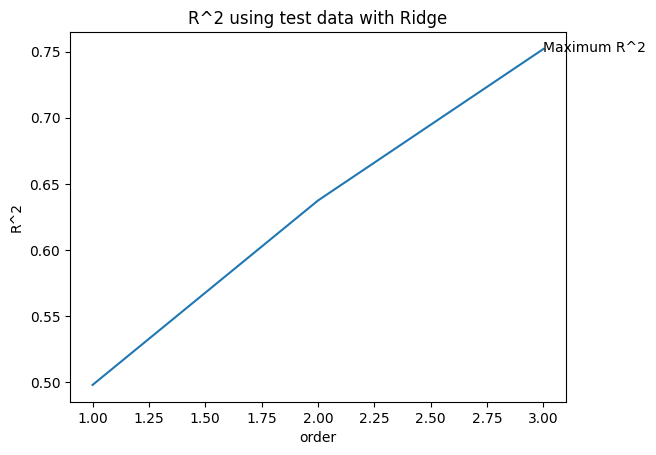

In [38]:
plt.plot(order, Rsq_test_ridge)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 using test data with Ridge')
plt.text(3,0.75,'Maximum R^2')

 => Bậc n tốt nhất để triển khai hồi quy đa thức ridge là 3.

##### Biểu đồ thể thiện mối quan hệ giữa bậc n và score trong trường hợp sử dụng LinearRegression

Text(3, 0.75, 'Maximum R^2')

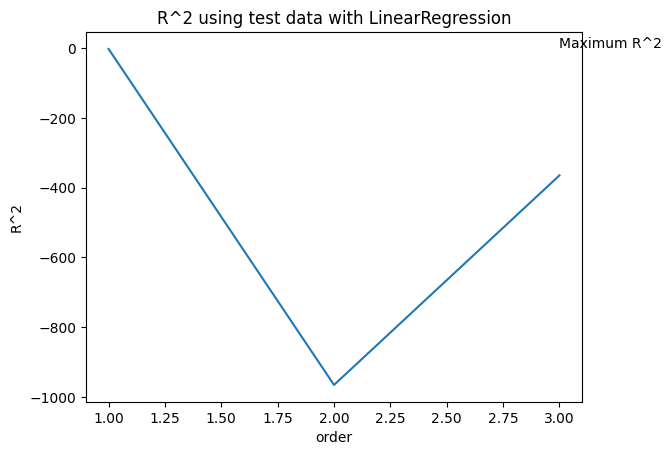

In [39]:
plt.plot(order, Rsq_test_lr)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 using test data with LinearRegression')
plt.text(3,0.75,'Maximum R^2')

=> Bậc n tốt nhất để triển khai hồi quy đa thức LinearRegression là 0.

##### Biểu đồ thể thiện mối quan hệ giữa bậc n và score trong trường hợp sử dụng RandomForestRegressor

Text(3, 0.75, 'Maximum R^2')

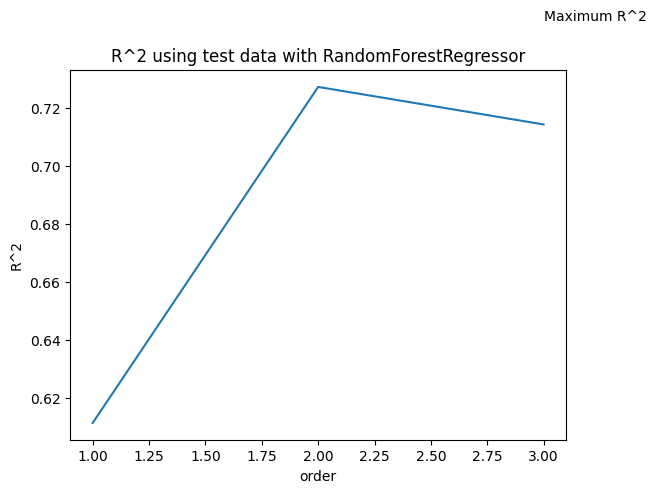

In [40]:
plt.plot(order, Rsq_test_rf)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 using test data with RandomForestRegressor')
plt.text(3,0.75,'Maximum R^2')

 => Bậc n tốt nhất để triển khai hồi quy đa thức RandomForestRegressor là 2.

#### Pipeline hồi quy đa thức Ridge

In [41]:
ridge_regression = Pipeline(steps=[('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=3,include_bias=False)),
                        ('ridge', Ridge(alpha=80))])

#### Pipeline hồi quy đa thức Linear Regression


In [42]:
linear_regression = Pipeline(steps=[('preprocessor', preprocessor),
                        #('poly', PolynomialFeatures(degree=0,include_bias=False)),
                        ('linear', LinearRegression())])

#### Pipeline hồi quy RandomForestRegressor

In [43]:
random_forest = Pipeline(steps=[('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=2,include_bias=False)),
                        ('rf', RandomForestRegressor(n_estimators=100,random_state=1))])

### 5. Triển khai mô hình, dự đoán và đánh giá

#### 5.1 Fit dữ liệu tập train

##### 5.1.1 Ridge

In [44]:
ridge_regression.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Cubic-capacity',
                                                   'Gears',
                                                   'Year-of-manufacture',
                                                   'Mileage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Model', 'Type', 'Make',
                                                   'Cooling'])])),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=80))])

##### 5.1.2 Linear Regression

In [45]:
linear_regression.fit(X_train, Y_train) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Cubic-capacity',
                                                   'Gears',
                                                   'Year-of-manufacture',
                                                   'Mileage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Model', 'Type', 'Make',
                                                   'Cooling'])])),
                ('linear', LinearRegression())])

##### 5.1.3 RandomForestRegressor

In [46]:
random_forest.fit(X_train, Y_train) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Cubic-capacity',
                                                   'Gears',
                                                   'Year-of-manufacture',
                                                   'Mileage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Model', 'Type', 'Make',
                                                   'Cooling'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('rf', RandomForestRegressor(random_state=1))])

#### 5.2 Thực hiện dự đoán trên tập test

##### 5.2.1 Ridge 

In [47]:
predict1 = ridge_regression.predict(X_test)

##### 5.2.2 LinearRegression

In [48]:
predict2 = linear_regression.predict(X_test)

##### 5.2.3 RandomForestRegressor

In [49]:
predict3 = random_forest.predict(X_test)

#### 5.3 Đánh giá mô hình:

##### 5.3.1 Ridge

In [50]:
print("Training sample:")
print("R-squared: ",ridge_regression.score(X_train,Y_train))

Training sample:
R-squared:  0.8811459681068238


In [51]:
print("Testing sample:")
print("R-squared: ",ridge_regression.score(X_test,Y_test))

Testing sample:
R-squared:  0.7521260588747011


In [52]:
print('Root mean squared error:', np.sqrt(mean_squared_error(Y_test,predict1)))

Root mean squared error: 5009.147725263549


In [53]:
cv_score = cross_val_score(ridge_regression, df[X],df[Y],cv=5)
print('Cross val score:', cv_score.mean())

Cross val score: 0.44178343959637356


##### 5.3.2 LinearRegression

In [54]:
print("Training sample:")
print("R-squared: ",ridge_regression.score(X_train,Y_train))

Training sample:
R-squared:  0.8811459681068238


In [55]:
print("Testing sample:")
print("R-squared: ",linear_regression.score(X_test,Y_test))
#r2_score(Y_test,predict)

Testing sample:
R-squared:  -2.454236416433714


In [56]:
print('Root mean squared error:', np.sqrt(mean_squared_error(Y_test,predict2)))

Root mean squared error: 18699.26054724856


In [57]:
cv_score = cross_val_score(ridge_regression, df[X],df[Y],cv=5)
print('Cross val score:', cv_score.mean())

Cross val score: 0.44178343959637356


##### Nhận xét: mô hình dự đoán với LinearRegression không khả quan

##### 5.3.3 RandomForestRegressor

In [58]:
print("Training sample:")
print("R-squared: ",random_forest.score(X_train,Y_train))

Training sample:
R-squared:  0.9193023746286662


In [59]:
print("Testing sample:")
print("R-squared: ",random_forest.score(X_test,Y_test))
#r2_score(Y_test,predict)

Testing sample:
R-squared:  0.7271043149667397


In [60]:
print('Root mean squared error:', np.sqrt(mean_squared_error(Y_test,predict3)))

Root mean squared error: 5255.895696996909


##### Nhận xét: mô hình bởi randomforestregressor mang lại kết quả chấp nhận được

#### 5.4 In ra kết quả dự đoán giá xe so với thực tế:

+ Ridge:

In [62]:
dict = {'Y_test':Y_test[:10],
        'Predict':predict1[:10]}
rs_test = pd.DataFrame(dict)
rs_test


,Y_test,Predict
84,2827,7059.49
256,2956,3346.50
134,19995,25152.21
285,12639,9575.37
263,2571,5434.21
61,6427,11395.99
158,4027,5651.71
324,2571,4070.15
23,21851,16607.32
31,16500,15359.44


* LinearRegression

In [63]:
dict2 = {'Y_test':Y_test[:10],
        'Predict':predict2[:10]}
rs_test = pd.DataFrame(dict2)
rs_test

,Y_test,Predict
84,2827,21939.11
256,2956,-13190.98
134,19995,25135.86
285,12639,-16771.59
263,2571,10007.17
61,6427,14244.82
158,4027,-5284.10
324,2571,-7956.34
23,21851,15848.36
31,16500,17796.85


* RandomForestRegressor

In [64]:
dict3 = {'Y_test':Y_test[:10],
        'Predict':predict3[:10]}
rs_test = pd.DataFrame(dict3)
rs_test

,Y_test,Predict
84,2827,6980.01
256,2956,3266.28
134,19995,34622.23
285,12639,8394.09
263,2571,3424.57
61,6427,9814.44
158,4027,3998.55
324,2571,3686.90
23,21851,10423.30
31,16500,19732.72


#### 5.5 Trực quan thể hiện tương quan giữa giá trị thực tế (màu xanh) và giá trị dự đoán (màu đỏ).

* Ridge

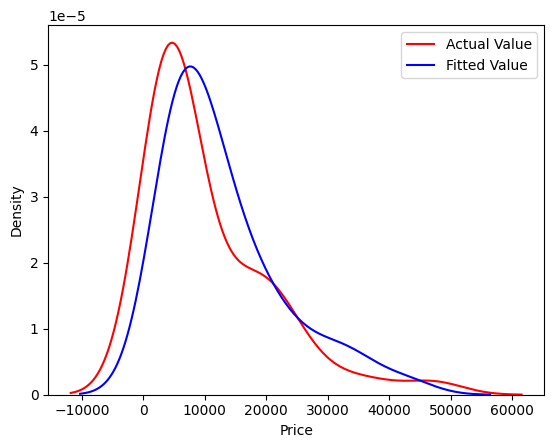

In [66]:
ax1 = sns.kdeplot(Y_test, color = 'r', label='Actual Value')
sns.kdeplot(predict1,color= 'b',label='Fitted Value',ax=ax1)
plt.legend()

##### Nhận xét: Mô hình dự đoán tốt, có xu hướng dự đoán giá trị một cách chính xác với giá trị thực tế. Cũng có thể nhận thấy các số đo hiệu suât như RMSE và R-squared ở mức cao tuy nhiên việc cross val score thấp có thể xem là một cảnh báo với hiệu suất của bộ dữ liệu.

* LinearRegression

<Axes: xlabel='Price', ylabel='Density'>

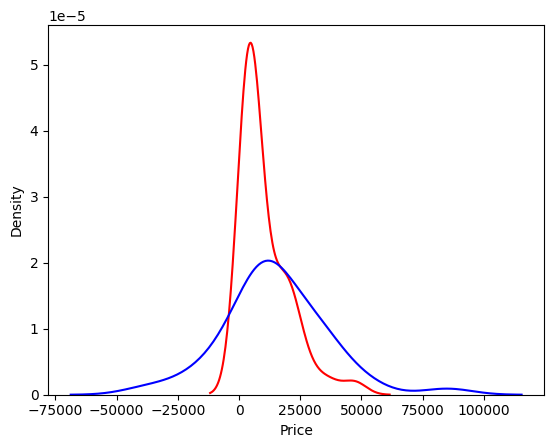

In [67]:
ax2 = sns.kdeplot(Y_test, color = 'r', label='Actual Value')
sns.kdeplot(predict2,color= 'b',label='Fitted Value',ax=ax2)

##### Nhận xét: Đường dữ liệu dự đoán so với thực tế không gần nhau cho thấy mô hình dự đoán chưa tốt với LinearRegression

* RandomForestRegressor

<Axes: xlabel='Price', ylabel='Density'>

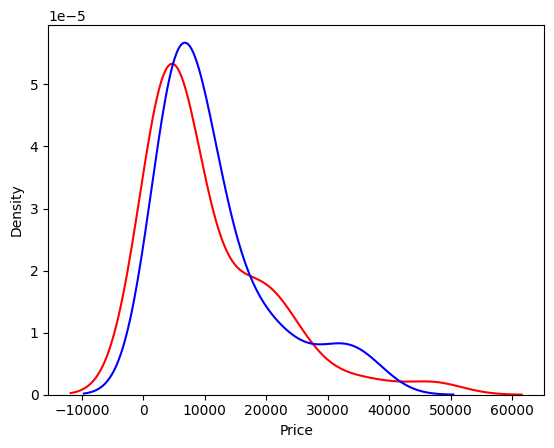

In [68]:
ax3 = sns.kdeplot(Y_test, color = 'r', label='Actual Value')
sns.kdeplot(predict3,color= 'b',label='Fitted Value',ax=ax3)

##### Nhận xét: Mô hình dự đoán tương đối tốt, có xu hướng dự đoán giá trị gần với giá trị thực tế. Đường dữ liệu dự đoán so với thực tế tương đối gần nhau.

Vậy mô hình dự đoán với hồi quy Ridge và RandomForestRegressor là tốt nhất